In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-4651ca27-b66e-6c3d-762e-50c867212723)


## Get data

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-03-21 13:53:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.03s   

2022-03-21 13:53:53 (5.78 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [ ]:
import pandas as pd

df = pd.read_csv('BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                 parse_dates=['Date'],
                 index_col=['Date'])

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [ ]:
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


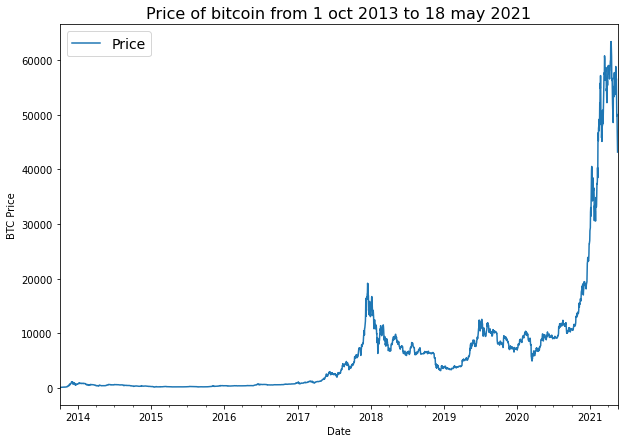

In [ ]:
import matplotlib.pyplot as plt

bitcoin_prices.plot(figsize=(10,7))
plt.ylabel('BTC Price')
plt.title('Price of bitcoin from 1 oct 2013 to 18 may 2021', fontsize=16)
plt.legend(fontsize=14);

In [ ]:
from sklearn.model_selection import train_test_split

timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(timesteps, prices,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2229,), (2229,), (558,), (558,))

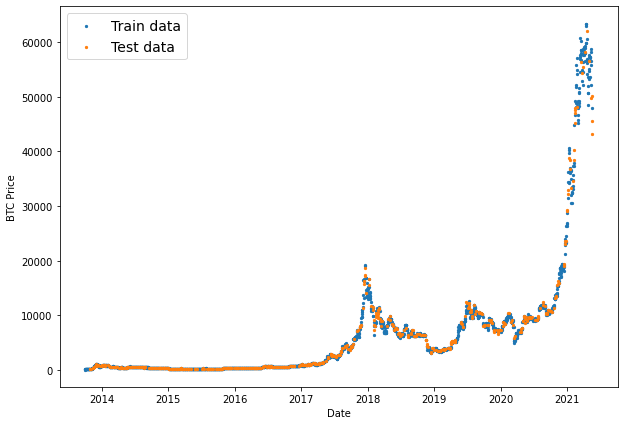

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show();

### Spliting data, correct way

In [ ]:
split_size = int(0.8 * len(prices))

X_train, y_train = timesteps[:split_size], prices[:split_size]

X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test)

(2229, 558)

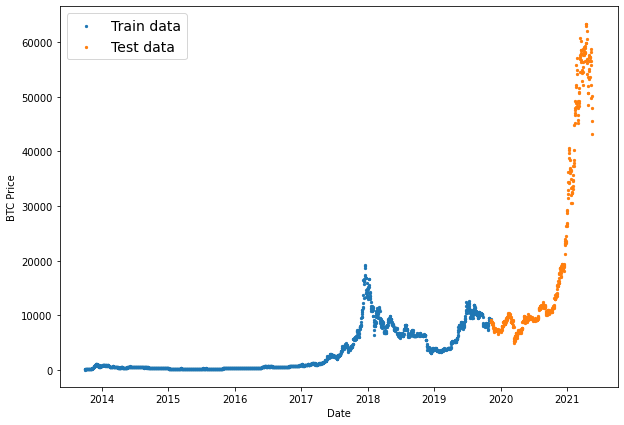

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show();

### Creating plot function

In [ ]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel('BTC Price')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

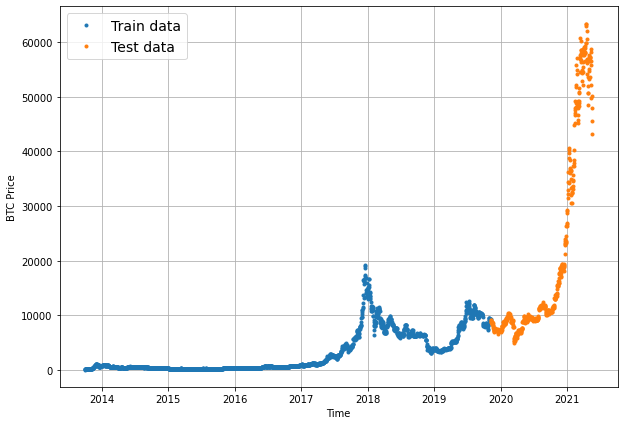

In [ ]:
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')

## Modelling Experiments

### Model 0: Naive forecast

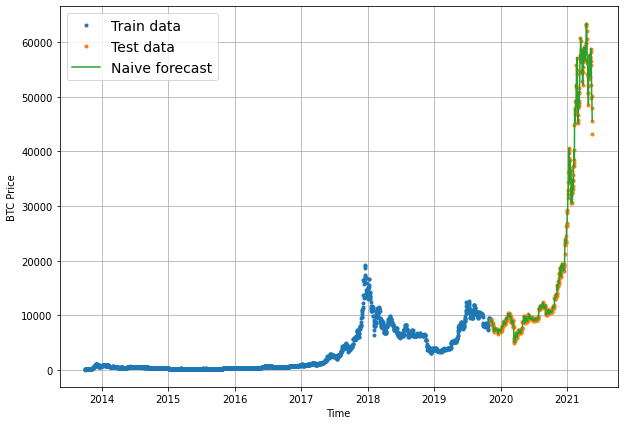

In [ ]:
naive_forecast = y_test[:-1]

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

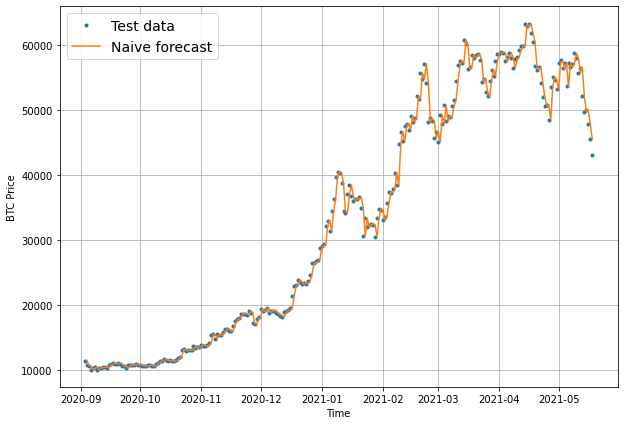

In [ ]:
plt.figure(figsize=(10, 7))
offset = 300
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

### Evaluating time series model

MASE - mean absolute scaled error

In [ ]:
import tensorflow as tf

def mean_absolute_scaled_error(y_true, y_pred):
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return mae / mae_naive_no_season


In [ ]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)

naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

### Windowing dataset

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
def get_labelled_windows(x, horizon=1):

  """
  input: [1,2,3,4,5,6], output: ([1,2,3,4,5], [6])
  """

  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [ ]:
import numpy as np

def make_windows(x, window_size=7, horizon=1):

  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)), axis=0).T
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  windowed_array = x[window_indexes]

  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)


  return windows, labels

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
for i in range(3):
  print(f'Windows: {full_windows[i]} -> Label: {full_labels[i]}')

Windows: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Windows: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Windows: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


### Turning windows into training and test sets

In [ ]:
def make_train_test_splits(windows, labels, test_split=0.2):

  split_size = int(len(windows) * (1 - test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

### Make a modelling checkpoint

In [ ]:
import os

def create_model_checkpoint(model_name, save_path='model_experiments'):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

### Model 1: Dense model (window=7, horizon=1)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
                               layers.Dense(128, activation='relu'),
                               layers.Dense(HORIZON, activation='linear')
], name='model_1_dense')

model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 [==============================] - 3s 50ms/step - loss: 780.3455 - mae: 780.3455 - val_loss: 2279.6526 - val_mae: 2279.6526
Epoch 2/100
18/18 [==============================] - 1s 33ms/step - loss: 247.6756 - mae: 247.6756 - val_loss: 1005.9991 - val_mae: 1005.9991
Epoch 3/100
18/18 [==============================] - 1s 34ms/step - loss: 188.4116 - mae: 188.4116 - val_loss: 923.2862 - val_mae: 923.2862
Epoch 4/100
18/18 [==============================] - 1s 33ms/step - loss: 169.4340 - mae: 169.4340 - val_loss: 900.5872 - val_mae: 900.5872
Epoch 5/100
18/18 [==============================] - 1s 34ms/step - loss: 165.0895 - mae: 165.0895 - val_loss: 895.2238 - val_mae: 895.2238
Epoch 6/100
18/18 [==============================] - 1s 34ms/step - loss: 158.5210 - mae: 158.5210 - val_loss: 855.1982 - val_mae: 855.1982
Epoch 7/100
18/18 [==============================] - 1s 43ms/step - loss: 151.3566 - mae: 151.3566 - val_loss: 840.9168 - val_mae: 840.9168
Epoch 8/100
18/1

In [ ]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 585.9762 - mae: 585.9762


[585.9761962890625, 585.9761962890625]

### Making forecasts

In [ ]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)

  return tf.squeeze(forecast)

In [ ]:
model_1_preds = make_preds(model_1, test_windows)

model_1_preds.shape, model_1_preds[:10]

(TensorShape([556]), <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8801.181, 8714.924, 8972.653, 8760.339, 8676.046, 8679.055,
        8641.017, 8451.333, 8412.064, 8468.017], dtype=float32)>)

In [ ]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_preds)

model_1_results

{'mae': 585.97626,
 'mape': 2.614913,
 'mase': 1.029398,
 'mse': 1197803.1,
 'rmse': 1094.4419}

In [ ]:
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

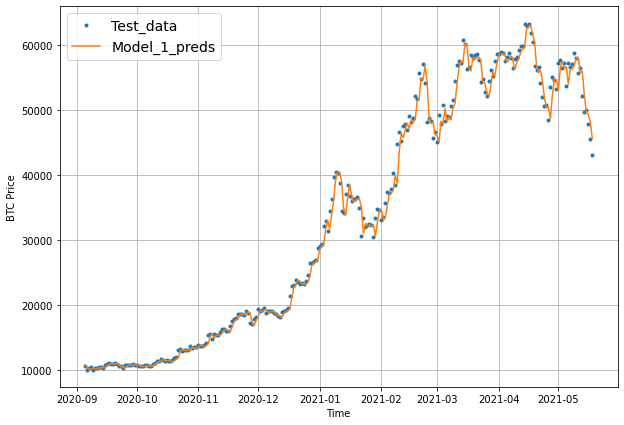

In [ ]:
offset = 300

plt.figure(figsize=(10, 7))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label='Test_data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format='-', label='Model_1_preds')

### Model 2: Dense, window=30, horizon=1

In [ ]:
HORIZON = 1
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [ ]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
                               layers.Dense(128, activation='relu'),
                               layers.Dense(HORIZON, activation='linear')
], name='model_2_dense')

model_2.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/100
18/18 [==============================] - 1s 40ms/step - loss: 1097.0397 - mae: 1097.0397 - val_loss: 3900.2532 - val_mae: 3900.2532
Epoch 2/100
18/18 [==============================] - 1s 33ms/step - loss: 428.0732 - mae: 428.0732 - val_loss: 1587.0747 - val_mae: 1587.0748
Epoch 3/100
18/18 [==============================] - 1s 33ms/step - loss: 279.7655 - mae: 279.7655 - val_loss: 1220.6887 - val_mae: 1220.6887
Epoch 4/100
18/18 [==============================] - 1s 32ms/step - loss: 224.3637 - mae: 224.3637 - val_loss: 1160.1571 - val_mae: 1160.1571
Epoch 5/100
18/18 [==============================] - 1s 33ms/step - loss: 187.9680 - mae: 187.9680 - val_loss: 1007.6487 - val_mae: 1007.6487
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 182.9174 - mae: 182.9174 - val_loss: 1019.5820 - val_mae: 1019.5820
Epoch 7/100
18/18 [==============================] - 0s 5ms/step - loss: 187.7612 - mae: 187.7612 - val_loss: 1145.1761 - val_mae: 1145.1761
Epoch 

In [ ]:
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 608.9615 - mae: 608.9615


[608.9614868164062, 608.9614868164062]

In [ ]:
# Load best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 608.9615 - mae: 608.9615


[608.9614868164062, 608.9614868164062]

In [ ]:
model_2_preds = make_preds(model_2, test_windows)

model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_2_preds)

model_2_results

{'mae': 608.9615,
 'mape': 2.7693386,
 'mase': 1.0644706,
 'mse': 1281438.8,
 'rmse': 1132.0065}

In [ ]:
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

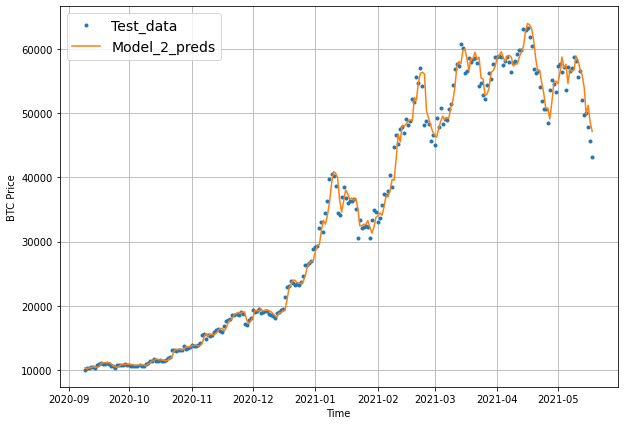

In [ ]:
offset = 300

plt.figure(figsize=(10, 7))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label='Test_data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format='-', label='Model_2_preds')

### Model 3: Dense, window=30, horizon=7

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [ ]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
                               layers.Dense(128, activation='relu'),
                               layers.Dense(HORIZON, activation='linear')
], name='model_3_dense')

model_3.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

model_3.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
18/18 [==============================] - 1s 40ms/step - loss: 1476.6752 - mae: 1476.6752 - val_loss: 3088.5618 - val_mae: 3088.5618
Epoch 2/100
18/18 [==============================] - 1s 33ms/step - loss: 552.8943 - mae: 552.8943 - val_loss: 2462.4548 - val_mae: 2462.4548
Epoch 3/100
18/18 [==============================] - 1s 32ms/step - loss: 435.1979 - mae: 435.1979 - val_loss: 2283.1482 - val_mae: 2283.1482
Epoch 4/100
18/18 [==============================] - 1s 33ms/step - loss: 391.9787 - mae: 391.9787 - val_loss: 1975.1218 - val_mae: 1975.1218
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 357.9485 - mae: 357.9485 - val_loss: 2000.1554 - val_mae: 2000.1554
Epoch 6/100
18/18 [==============================] - 1s 34ms/step - loss: 332.6705 - mae: 332.6705 - val_loss: 1723.4183 - val_mae: 1723.4183
Epoch 7/100
18/18 [==============================] - 1s 33ms/step - loss: 309.9903 - mae: 309.9903 - val_loss: 1591.9685 - val_mae: 1591.9685
Epoch

In [ ]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1321.5200 - mae: 1321.5200


[1321.52001953125, 1321.52001953125]

In [ ]:
#load best model
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1237.5063 - mae: 1237.5063


[1237.50634765625, 1237.50634765625]

In [ ]:
model_3_preds = make_preds(model_3, input_data=test_windows)

model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9004.693 , 9048.1   , 9425.088 , 9258.259 , 9495.798 , 9558.451 ,
        9357.354 ],
       [8735.507 , 8840.304 , 9247.793 , 8885.6   , 9097.188 , 9174.328 ,
        9156.819 ],
       [8672.508 , 8782.388 , 9123.855 , 8770.371 , 9007.13  , 9003.87  ,
        9042.723 ],
       [8874.398 , 8784.737 , 9043.901 , 8943.051 , 9033.479 , 9176.488 ,
        9039.676 ],
       [8825.891 , 8777.4375, 8926.779 , 8870.178 , 9213.232 , 9268.156 ,
        8942.485 ]], dtype=float32)>

In [ ]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  if mae.ndim > 0: 
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
model_3_results = evaluate_preds(y_true=test_labels, y_pred=model_3_preds)

model_3_results

{'mae': 1237.5063,
 'mape': 5.5588784,
 'mase': 2.2020736,
 'mse': 5405197.5,
 'rmse': 1425.7479}

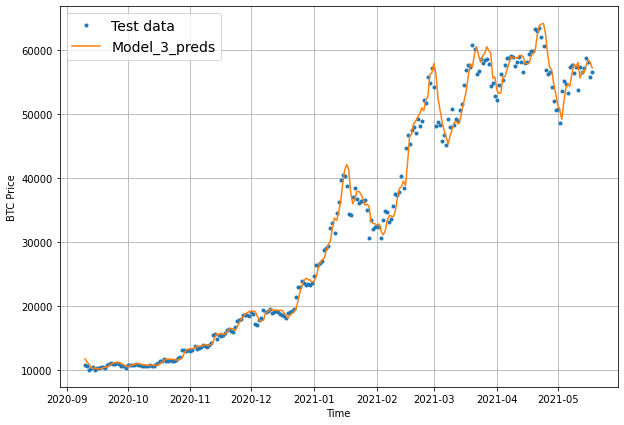

In [ ]:
offset = 300

plt.figure(figsize=(10, 7))

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label='Test data')
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 format='-',
                 start=offset,
                 label='Model_3_preds')

### Best perfoming model so far

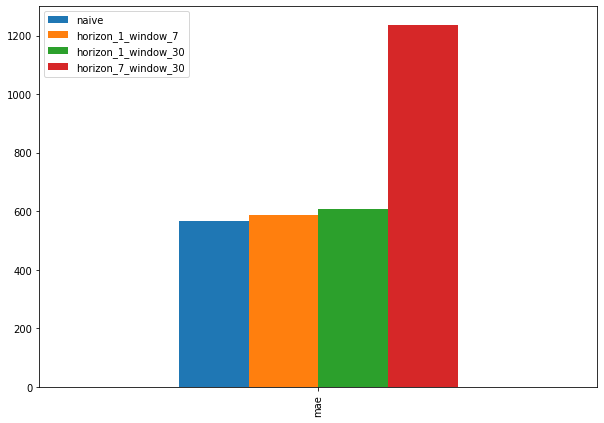

In [ ]:
pd.DataFrame({'naive': naive_results['mae'],
              'horizon_1_window_7': model_1_results['mae'],
              'horizon_1_window_30': model_2_results['mae'],
              'horizon_7_window_30': model_3_results['mae']}, index=['mae']).plot(figsize=(10,7), kind='bar')

### Model 4: Conv1D

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
train_windows[0].shape, train_windows[0]

((7,), array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  ]))

In [ ]:
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))

expand_dims_layer(x).shape, expand_dims_layer(x)

(TensorShape([7, 1]), <tf.Tensor: shape=(7, 1), dtype=float32, numpy=
 array([[123.65499],
        [125.455  ],
        [108.58483],
        [118.67466],
        [121.33866],
        [120.65533],
        [121.795  ]], dtype=float32)>)

In [ ]:
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
                               layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
                               layers.Conv1D(filters=128, kernel_size=5, padding='causal', activation='relu'),
                               layers.Dense(HORIZON)
], name='model_4_conv1D')

model_4.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/100
18/18 [==============================] - 8s 60ms/step - loss: 1207.3817 - mae: 1207.3817 - val_loss: 2320.6218 - val_mae: 2320.6218
Epoch 2/100
18/18 [==============================] - 1s 48ms/step - loss: 316.2171 - mae: 316.2171 - val_loss: 1467.2798 - val_mae: 1467.2798
Epoch 3/100
18/18 [==============================] - 1s 48ms/step - loss: 192.6853 - mae: 192.6853 - val_loss: 1164.7074 - val_mae: 1164.7074
Epoch 4/100
18/18 [==============================] - 1s 48ms/step - loss: 177.3535 - mae: 177.3535 - val_loss: 981.6694 - val_mae: 981.6694
Epoch 5/100
18/18 [==============================] - 1s 49ms/step - loss: 172.3466 - mae: 172.3466 - val_loss: 960.8710 - val_mae: 960.8710
Epoch 6/100
18/18 [==============================] - 1s 48ms/step - loss: 171.9753 - mae: 171.9753 - val_loss: 950.2027 - val_mae: 950.2027
Epoch 7/100
18/18 [==============================] - 1s 48ms/step - loss: 167.1944 - mae: 167.1944 - val_loss: 943.2872 - val_mae: 943.2872
Epoch 8/100


In [ ]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_4 = tf.keras.models.load_model('model_experiments/model_4_conv1D')
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 570.8285 - mae: 570.8285


[570.8284912109375, 570.8284912109375]

In [ ]:
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8851.463, 8754.47 , 8983.928, 8759.671, 8703.627, 8708.294,
       8661.667, 8494.839, 8435.316, 8492.114], dtype=float32)>

In [ ]:
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)

model_4_results

{'mae': 570.8285,
 'mape': 2.5593362,
 'mase': 1.0027876,
 'mse': 1176671.5,
 'rmse': 1084.7449}

### Model 5: RNN (LSTM)

In [ ]:
tf.random.set_seed(42)

inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name='model_5_lstm')

model_5.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

model_5.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
14/18 [======================>.......] - ETA: 0s - loss: 2302.4456 - mae: 2302.4456INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 4s 159ms/step - loss: 2109.7380 - mae: 2109.7380 - val_loss: 3774.6191 - val_mae: 3774.6191
Epoch 2/100
15/18 [========================>.....] - ETA: 0s - loss: 317.4500 - mae: 317.4500INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 3s 161ms/step - loss: 305.1035 - mae: 305.1035 - val_loss: 1632.6014 - val_mae: 1632.6014
Epoch 3/100
15/18 [========================>.....] - ETA: 0s - loss: 189.9086 - mae: 189.9086INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 140ms/step - loss: 186.4842 - mae: 186.4842 - val_loss: 1082.3761 - val_mae: 1082.3761
Epoch 4/100
14/18 [======================>.......] - ETA: 0s - loss: 170.8261 - mae: 170.8261INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 143ms/step - loss: 165.1016 - mae: 165.1016 - val_loss: 887.7894 - val_mae: 887.7894
Epoch 5/100
16/18 [=========================>....] - ETA: 0s - loss: 160.2244 - mae: 160.2244INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 3s 160ms/step - loss: 158.3267 - mae: 158.3267 - val_loss: 881.4151 - val_mae: 881.4151
Epoch 6/100
18/18 [==============================] - 0s 9ms/step - loss: 160.2730 - mae: 160.2730 - val_loss: 893.7048 - val_mae: 893.7048
Epoch 7/100
14/18 [======================>.......] - ETA: 0s - loss: 165.1084 - mae: 165.1084INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 143ms/step - loss: 158.9689 - mae: 158.9689 - val_loss: 856.5366 - val_mae: 856.5366
Epoch 8/100
17/18 [===========================>..] - ETA: 0s - loss: 155.2330 - mae: 155.2330INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 139ms/step - loss: 155.4264 - mae: 155.4264 - val_loss: 853.3630 - val_mae: 853.3630
Epoch 9/100
18/18 [==============================] - 0s 9ms/step - loss: 157.6190 - mae: 157.6190 - val_loss: 862.8422 - val_mae: 862.8422
Epoch 10/100
16/18 [=========================>....] - ETA: 0s - loss: 150.3782 - mae: 150.3782INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 138ms/step - loss: 152.2676 - mae: 152.2676 - val_loss: 826.8486 - val_mae: 826.8486
Epoch 11/100
16/18 [=========================>....] - ETA: 0s - loss: 146.3659 - mae: 146.3659INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 3s 158ms/step - loss: 147.5030 - mae: 147.5030 - val_loss: 823.7849 - val_mae: 823.7849
Epoch 12/100
18/18 [==============================] - 0s 9ms/step - loss: 143.9101 - mae: 143.9101 - val_loss: 849.4220 - val_mae: 849.4220
Epoch 13/100
18/18 [==============================] - 0s 10ms/step - loss: 145.4514 - mae: 145.4514 - val_loss: 904.8773 - val_mae: 904.8773
Epoch 14/100
18/18 [==============================] - 0s 9ms/step - loss: 143.2060 - mae: 143.2060 - val_loss: 865.4114 - val_mae: 865.4114
Epoch 15/100
16/18 [=========================>....] - ETA: 0s - loss: 142.7285 - mae: 142.7285INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 138ms/step - loss: 140.6755 - mae: 140.6755 - val_loss: 794.9560 - val_mae: 794.9560
Epoch 16/100
16/18 [=========================>....] - ETA: 0s - loss: 134.9828 - mae: 134.9828INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 137ms/step - loss: 136.7215 - mae: 136.7215 - val_loss: 787.5330 - val_mae: 787.5330
Epoch 17/100
18/18 [==============================] - 0s 10ms/step - loss: 134.0416 - mae: 134.0416 - val_loss: 834.0011 - val_mae: 834.0011
Epoch 18/100
16/18 [=========================>....] - ETA: 0s - loss: 138.1922 - mae: 138.1922INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 3s 154ms/step - loss: 134.4735 - mae: 134.4735 - val_loss: 756.9277 - val_mae: 756.9277
Epoch 19/100
15/18 [========================>.....] - ETA: 0s - loss: 129.6380 - mae: 129.6380INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 141ms/step - loss: 130.2251 - mae: 130.2251 - val_loss: 750.5060 - val_mae: 750.5060
Epoch 20/100
16/18 [=========================>....] - ETA: 0s - loss: 127.4058 - mae: 127.4058INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 140ms/step - loss: 128.0871 - mae: 128.0871 - val_loss: 707.3749 - val_mae: 707.3749
Epoch 21/100
18/18 [==============================] - 0s 9ms/step - loss: 131.9368 - mae: 131.9368 - val_loss: 721.4482 - val_mae: 721.4482
Epoch 22/100
18/18 [==============================] - 0s 9ms/step - loss: 125.5536 - mae: 125.5536 - val_loss: 729.3652 - val_mae: 729.3652
Epoch 23/100
16/18 [=========================>....] - ETA: 0s - loss: 126.6324 - mae: 126.6324INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 3s 156ms/step - loss: 127.6705 - mae: 127.6705 - val_loss: 679.4035 - val_mae: 679.4035
Epoch 24/100
16/18 [=========================>....] - ETA: 0s - loss: 125.8784 - mae: 125.8784INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 143ms/step - loss: 124.8391 - mae: 124.8391 - val_loss: 677.6516 - val_mae: 677.6516
Epoch 25/100
15/18 [========================>.....] - ETA: 0s - loss: 127.9236 - mae: 127.9236INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 141ms/step - loss: 122.7973 - mae: 122.7973 - val_loss: 664.8735 - val_mae: 664.8735
Epoch 26/100
17/18 [===========================>..] - ETA: 0s - loss: 122.6078 - mae: 122.6078INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 136ms/step - loss: 122.9217 - mae: 122.9217 - val_loss: 663.0863 - val_mae: 663.0863
Epoch 27/100
16/18 [=========================>....] - ETA: 0s - loss: 124.7003 - mae: 124.7003INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 3s 160ms/step - loss: 124.7652 - mae: 124.7652 - val_loss: 652.6631 - val_mae: 652.6631
Epoch 28/100
18/18 [==============================] - 0s 9ms/step - loss: 120.4272 - mae: 120.4272 - val_loss: 675.0215 - val_mae: 675.0215
Epoch 29/100
18/18 [==============================] - 0s 9ms/step - loss: 120.9682 - mae: 120.9682 - val_loss: 661.6725 - val_mae: 661.6725
Epoch 30/100
16/18 [=========================>....] - ETA: 0s - loss: 127.2394 - mae: 127.2394INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 141ms/step - loss: 128.3299 - mae: 128.3299 - val_loss: 642.5264 - val_mae: 642.5264
Epoch 31/100
18/18 [==============================] - 0s 9ms/step - loss: 117.9305 - mae: 117.9305 - val_loss: 695.3829 - val_mae: 695.3829
Epoch 32/100
16/18 [=========================>....] - ETA: 0s - loss: 117.4283 - mae: 117.4283INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 140ms/step - loss: 118.8332 - mae: 118.8332 - val_loss: 640.7852 - val_mae: 640.7852
Epoch 33/100
18/18 [==============================] - 0s 9ms/step - loss: 117.7867 - mae: 117.7867 - val_loss: 665.8848 - val_mae: 665.8848
Epoch 34/100
15/18 [========================>.....] - ETA: 0s - loss: 118.1952 - mae: 118.1952INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 3s 159ms/step - loss: 118.3849 - mae: 118.3849 - val_loss: 626.0911 - val_mae: 626.0911
Epoch 35/100
18/18 [==============================] - 0s 9ms/step - loss: 117.1671 - mae: 117.1671 - val_loss: 641.9799 - val_mae: 641.9799
Epoch 36/100
18/18 [==============================] - 0s 11ms/step - loss: 120.4977 - mae: 120.4977 - val_loss: 629.2457 - val_mae: 629.2457
Epoch 37/100
18/18 [==============================] - 0s 10ms/step - loss: 118.7800 - mae: 118.7800 - val_loss: 646.4763 - val_mae: 646.4763
Epoch 38/100
18/18 [==============================] - 0s 10ms/step - loss: 116.8447 - mae: 116.8447 - val_loss: 644.3025 - val_mae: 644.3025
Epoch 39/100
15/18 [========================>.....] - ETA: 0s - loss: 118.7474 - mae: 118.7474INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 140ms/step - loss: 115.4268 - mae: 115.4268 - val_loss: 612.9471 - val_mae: 612.9471
Epoch 40/100
17/18 [===========================>..] - ETA: 0s - loss: 114.8495 - mae: 114.8495INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 139ms/step - loss: 114.4212 - mae: 114.4212 - val_loss: 612.7279 - val_mae: 612.7279
Epoch 41/100
16/18 [=========================>....] - ETA: 0s - loss: 115.3849 - mae: 115.3849INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 3s 161ms/step - loss: 113.6715 - mae: 113.6715 - val_loss: 608.6282 - val_mae: 608.6282
Epoch 42/100
18/18 [==============================] - 0s 9ms/step - loss: 120.9440 - mae: 120.9440 - val_loss: 671.8546 - val_mae: 671.8546
Epoch 43/100
18/18 [==============================] - 0s 10ms/step - loss: 122.6483 - mae: 122.6483 - val_loss: 703.8080 - val_mae: 703.8080
Epoch 44/100
15/18 [========================>.....] - ETA: 0s - loss: 117.9549 - mae: 117.9549INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 142ms/step - loss: 117.5125 - mae: 117.5125 - val_loss: 603.8834 - val_mae: 603.8834
Epoch 45/100
18/18 [==============================] - 0s 9ms/step - loss: 112.4526 - mae: 112.4526 - val_loss: 605.1710 - val_mae: 605.1710
Epoch 46/100
18/18 [==============================] - 0s 9ms/step - loss: 114.0052 - mae: 114.0052 - val_loss: 632.7053 - val_mae: 632.7053
Epoch 47/100
18/18 [==============================] - 0s 9ms/step - loss: 113.8921 - mae: 113.8921 - val_loss: 620.0701 - val_mae: 620.0701
Epoch 48/100
18/18 [==============================] - 0s 10ms/step - loss: 112.3252 - mae: 112.3252 - val_loss: 607.2523 - val_mae: 607.2523
Epoch 49/100
18/18 [==============================] - 0s 10ms/step - loss: 114.7780 - mae: 114.7780 - val_loss: 739.4542 - val_mae: 739.4542
Epoch 50/100
18/18 [==============================] - 0s 10ms/step - loss: 124.8359 - mae: 124.8359 - val_loss: 627.8898 - val_mae: 627.8898
Epoch 51/100
15/18 [========

INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 141ms/step - loss: 113.8093 - mae: 113.8093 - val_loss: 595.5711 - val_mae: 595.5711
Epoch 52/100
18/18 [==============================] - 0s 10ms/step - loss: 116.5918 - mae: 116.5918 - val_loss: 611.0508 - val_mae: 611.0508
Epoch 53/100
18/18 [==============================] - 0s 9ms/step - loss: 113.2726 - mae: 113.2726 - val_loss: 607.0103 - val_mae: 607.0103
Epoch 54/100
18/18 [==============================] - 0s 9ms/step - loss: 111.9871 - mae: 111.9871 - val_loss: 621.1563 - val_mae: 621.1563
Epoch 55/100
18/18 [==============================] - 0s 9ms/step - loss: 114.7494 - mae: 114.7494 - val_loss: 608.6375 - val_mae: 608.6375
Epoch 56/100
18/18 [==============================] - 0s 9ms/step - loss: 110.9671 - mae: 110.9671 - val_loss: 748.4055 - val_mae: 748.4055
Epoch 57/100
16/18 [=========================>....] - ETA: 0s - loss: 116.1199 - mae: 116.1199INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 3s 163ms/step - loss: 114.4905 - mae: 114.4905 - val_loss: 589.7370 - val_mae: 589.7370
Epoch 58/100
18/18 [==============================] - 0s 9ms/step - loss: 113.4405 - mae: 113.4405 - val_loss: 600.3420 - val_mae: 600.3420
Epoch 59/100
18/18 [==============================] - 0s 9ms/step - loss: 110.3249 - mae: 110.3249 - val_loss: 591.2457 - val_mae: 591.2457
Epoch 60/100
18/18 [==============================] - 0s 9ms/step - loss: 114.9428 - mae: 114.9428 - val_loss: 657.6204 - val_mae: 657.6204
Epoch 61/100
15/18 [========================>.....] - ETA: 0s - loss: 114.6313 - mae: 114.6313INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 144ms/step - loss: 112.4345 - mae: 112.4345 - val_loss: 586.2318 - val_mae: 586.2318
Epoch 62/100
18/18 [==============================] - 0s 10ms/step - loss: 109.4190 - mae: 109.4190 - val_loss: 589.3013 - val_mae: 589.3013
Epoch 63/100
18/18 [==============================] - 0s 9ms/step - loss: 109.2286 - mae: 109.2286 - val_loss: 593.3893 - val_mae: 593.3893
Epoch 64/100
18/18 [==============================] - 0s 9ms/step - loss: 109.0938 - mae: 109.0938 - val_loss: 633.4185 - val_mae: 633.4185
Epoch 65/100
16/18 [=========================>....] - ETA: 0s - loss: 114.1848 - mae: 114.1848INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 144ms/step - loss: 114.9697 - mae: 114.9697 - val_loss: 582.2736 - val_mae: 582.2736
Epoch 66/100
18/18 [==============================] - 0s 10ms/step - loss: 108.6964 - mae: 108.6964 - val_loss: 583.5541 - val_mae: 583.5541
Epoch 67/100
18/18 [==============================] - 0s 10ms/step - loss: 108.7128 - mae: 108.7128 - val_loss: 614.3140 - val_mae: 614.3140
Epoch 68/100
18/18 [==============================] - 0s 9ms/step - loss: 115.8837 - mae: 115.8837 - val_loss: 604.0801 - val_mae: 604.0801
Epoch 69/100
18/18 [==============================] - 0s 9ms/step - loss: 118.4847 - mae: 118.4847 - val_loss: 696.9655 - val_mae: 696.9655
Epoch 70/100
18/18 [==============================] - 0s 9ms/step - loss: 121.9756 - mae: 121.9756 - val_loss: 678.2755 - val_mae: 678.2755
Epoch 71/100
15/18 [========================>.....] - ETA: 0s - loss: 110.5320 - mae: 110.5320INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 142ms/step - loss: 111.5341 - mae: 111.5341 - val_loss: 581.8530 - val_mae: 581.8530
Epoch 72/100
18/18 [==============================] - 0s 9ms/step - loss: 111.4164 - mae: 111.4164 - val_loss: 642.3542 - val_mae: 642.3542
Epoch 73/100
18/18 [==============================] - 0s 10ms/step - loss: 113.8003 - mae: 113.8003 - val_loss: 605.0134 - val_mae: 605.0134
Epoch 74/100
18/18 [==============================] - 0s 9ms/step - loss: 116.8242 - mae: 116.8242 - val_loss: 595.3072 - val_mae: 595.3072
Epoch 75/100
18/18 [==============================] - 0s 9ms/step - loss: 115.7103 - mae: 115.7103 - val_loss: 628.3372 - val_mae: 628.3372
Epoch 76/100
18/18 [==============================] - 0s 9ms/step - loss: 116.6956 - mae: 116.6956 - val_loss: 606.6792 - val_mae: 606.6792
Epoch 77/100
16/18 [=========================>....] - ETA: 0s - loss: 109.7028 - mae: 109.7028INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 3s 160ms/step - loss: 108.4208 - mae: 108.4208 - val_loss: 576.5529 - val_mae: 576.5529
Epoch 78/100
18/18 [==============================] - 0s 9ms/step - loss: 109.7365 - mae: 109.7365 - val_loss: 597.2581 - val_mae: 597.2581
Epoch 79/100
18/18 [==============================] - 0s 10ms/step - loss: 110.9911 - mae: 110.9911 - val_loss: 596.1296 - val_mae: 596.1296
Epoch 80/100
18/18 [==============================] - 0s 9ms/step - loss: 113.4992 - mae: 113.4992 - val_loss: 608.1594 - val_mae: 608.1594
Epoch 81/100
18/18 [==============================] - 0s 9ms/step - loss: 109.1511 - mae: 109.1511 - val_loss: 621.4102 - val_mae: 621.4102
Epoch 82/100
18/18 [==============================] - 0s 9ms/step - loss: 121.7663 - mae: 121.7663 - val_loss: 581.7457 - val_mae: 581.7457
Epoch 83/100
18/18 [==============================] - 0s 9ms/step - loss: 118.4649 - mae: 118.4649 - val_loss: 698.5865 - val_mae: 698.5865
Epoch 84/100
18/18 [==========

INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 140ms/step - loss: 110.9420 - mae: 110.9420 - val_loss: 573.8184 - val_mae: 573.8184
Epoch 87/100
18/18 [==============================] - 0s 10ms/step - loss: 108.2899 - mae: 108.2899 - val_loss: 593.4805 - val_mae: 593.4805
Epoch 88/100
18/18 [==============================] - 0s 10ms/step - loss: 109.6193 - mae: 109.6193 - val_loss: 611.5809 - val_mae: 611.5809
Epoch 89/100
18/18 [==============================] - 0s 10ms/step - loss: 109.0726 - mae: 109.0726 - val_loss: 589.0883 - val_mae: 589.0883
Epoch 90/100
18/18 [==============================] - 0s 10ms/step - loss: 111.2584 - mae: 111.2584 - val_loss: 602.0399 - val_mae: 602.0399
Epoch 91/100
18/18 [==============================] - 0s 10ms/step - loss: 114.4485 - mae: 114.4485 - val_loss: 591.5786 - val_mae: 591.5786
Epoch 92/100
18/18 [==============================] - 0s 9ms/step - loss: 112.9170 - mae: 112.9170 - val_loss: 584.5344 - val_mae: 584.5344
Epoch 93/100
18/18 [======

INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 141ms/step - loss: 111.2232 - mae: 111.2232 - val_loss: 573.7051 - val_mae: 573.7051
Epoch 96/100
18/18 [==============================] - 0s 9ms/step - loss: 119.2409 - mae: 119.2409 - val_loss: 749.9863 - val_mae: 749.9863
Epoch 97/100
18/18 [==============================] - 0s 9ms/step - loss: 114.9015 - mae: 114.9015 - val_loss: 583.5004 - val_mae: 583.5004
Epoch 98/100
18/18 [==============================] - 0s 9ms/step - loss: 109.3497 - mae: 109.3497 - val_loss: 584.6735 - val_mae: 584.6735
Epoch 99/100
18/18 [==============================] - 0s 9ms/step - loss: 108.2898 - mae: 108.2898 - val_loss: 579.0339 - val_mae: 579.0339
Epoch 100/100
18/18 [==============================] - 0s 10ms/step - loss: 110.3740 - mae: 110.3740 - val_loss: 591.7518 - val_mae: 591.7518


In [ ]:
model_5 = tf.keras.models.load_model('model_experiments/model_5_lstm')
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 573.7051 - mae: 573.7051


[573.7051391601562, 573.7051391601562]

In [ ]:
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8929.299, 8809.119, 9048.751, 8835.96 , 8772.141], dtype=float32)>

In [ ]:
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_5_preds)

model_5_results

{'mae': 573.70514,
 'mape': 2.5752146,
 'mase': 1.007841,
 'mse': 1192443.6,
 'rmse': 1091.9907}

## Make multivariate time series

let's use bitcoin block reward size to try to make best predictions

In [ ]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [ ]:
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days

bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block['block_reward'] = None

bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


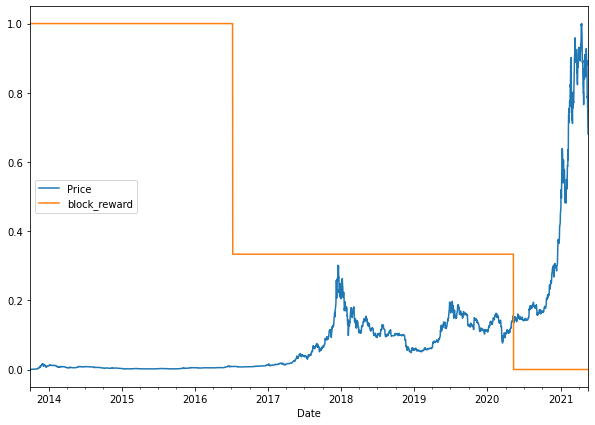

In [ ]:
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

### Making windowed dataset with pandas

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

bitcoin_prices_windowed = bitcoin_prices_block.copy()

for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)

bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [ ]:
X = bitcoin_prices_windowed.dropna().drop('Price', axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()['Price'].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [ ]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [ ]:
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

### Model 6: Dense (multivariate time series)

In [ ]:
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([
                               layers.Dense(128, activation='relu'),
                               layers.Dense(HORIZON)
], name='model_6_dense_multivariate')

model_6.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

model_6.fit(X_train, y_train,
                epochs=100,
                batch_size=128,
                validation_data=(X_test, y_test),
                callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 1256.0107INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 41ms/step - loss: 1234.6805 - val_loss: 2061.8848
Epoch 2/100
13/18 [====================>.........] - ETA: 0s - loss: 385.2514INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 35ms/step - loss: 351.5053 - val_loss: 1908.6812
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 249.1731INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 32ms/step - loss: 235.4153 - val_loss: 1329.0609
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 271.0341INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 32ms/step - loss: 208.6112 - val_loss: 1102.1311
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 196.5770 - val_loss: 1107.8497
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 145.3367INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 32ms/step - loss: 187.2244 - val_loss: 1036.1698
Epoch 7/100
18/18 [==============================] - ETA: 0s - loss: 182.0245INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 31ms/step - loss: 182.0245 - val_loss: 1019.2944
Epoch 8/100
17/18 [===========================>..] - ETA: 0s - loss: 175.4780INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 31ms/step - loss: 175.7059 - val_loss: 977.8504
Epoch 9/100
 1/18 [>.............................] - ETA: 0s - loss: 142.1689INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 32ms/step - loss: 170.1784 - val_loss: 954.4049
Epoch 10/100
18/18 [==============================] - ETA: 0s - loss: 164.4430INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 32ms/step - loss: 164.4430 - val_loss: 913.5159
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 171.3627INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 32ms/step - loss: 158.6892 - val_loss: 874.2512
Epoch 12/100
18/18 [==============================] - ETA: 0s - loss: 152.0732INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 32ms/step - loss: 152.0732 - val_loss: 861.0421
Epoch 13/100
18/18 [==============================] - 0s 5ms/step - loss: 151.1057 - val_loss: 886.1205
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 152.2399INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 32ms/step - loss: 147.5482 - val_loss: 837.8616
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 146.6368INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 33ms/step - loss: 142.3497 - val_loss: 794.4787
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 125.8471INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 32ms/step - loss: 137.5206 - val_loss: 778.4051
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 125.1489INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 47ms/step - loss: 135.8191 - val_loss: 772.4531
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 145.6096INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 33ms/step - loss: 134.8562 - val_loss: 747.4803
Epoch 19/100
18/18 [==============================] - 0s 5ms/step - loss: 130.3347 - val_loss: 761.0551
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 145.2514INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 32ms/step - loss: 128.6775 - val_loss: 701.8981
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 158.9075INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 32ms/step - loss: 129.5576 - val_loss: 691.0132
Epoch 22/100
17/18 [===========================>..] - ETA: 0s - loss: 126.2893INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 32ms/step - loss: 125.8060 - val_loss: 684.4122
Epoch 23/100
18/18 [==============================] - 0s 6ms/step - loss: 125.5263 - val_loss: 692.1297
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 134.1221INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 34ms/step - loss: 122.4765 - val_loss: 674.2216
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 133.5672INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 32ms/step - loss: 121.1171 - val_loss: 669.6432
Epoch 26/100
18/18 [==============================] - 0s 6ms/step - loss: 127.2623 - val_loss: 690.0403
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 180.3231INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 33ms/step - loss: 124.6204 - val_loss: 643.9723
Epoch 28/100
18/18 [==============================] - 0s 6ms/step - loss: 118.2544 - val_loss: 656.2765
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 109.8149INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 31ms/step - loss: 119.6374 - val_loss: 633.4545
Epoch 30/100
 1/18 [>.............................] - ETA: 0s - loss: 130.2604INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 33ms/step - loss: 119.5001 - val_loss: 625.3950
Epoch 31/100
18/18 [==============================] - 0s 5ms/step - loss: 114.5633 - val_loss: 668.5065
Epoch 32/100
18/18 [==============================] - ETA: 0s - loss: 116.9750INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 33ms/step - loss: 116.9750 - val_loss: 617.1058
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 115.2438 - val_loss: 649.0998
Epoch 34/100
18/18 [==============================] - 0s 6ms/step - loss: 114.5187 - val_loss: 632.1383
Epoch 35/100
 1/18 [>.............................] - ETA: 0s - loss: 112.6760INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 31ms/step - loss: 113.6357 - val_loss: 607.4178
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 115.2605 - val_loss: 626.4328
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 141.7286INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 32ms/step - loss: 113.7021 - val_loss: 606.2327
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 107.1736INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 32ms/step - loss: 111.4061 - val_loss: 603.2928
Epoch 39/100
 1/18 [>.............................] - ETA: 0s - loss: 127.4214INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 32ms/step - loss: 112.7722 - val_loss: 596.0070
Epoch 40/100
18/18 [==============================] - ETA: 0s - loss: 110.5418INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 33ms/step - loss: 110.5418 - val_loss: 593.2180
Epoch 41/100
18/18 [==============================] - 0s 5ms/step - loss: 110.8671 - val_loss: 609.1075
Epoch 42/100
18/18 [==============================] - 0s 5ms/step - loss: 115.7249 - val_loss: 607.4883
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 111.3313 - val_loss: 606.2040
Epoch 44/100
 1/18 [>.............................] - ETA: 0s - loss: 65.3244INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 31ms/step - loss: 109.7027 - val_loss: 586.1223
Epoch 45/100
18/18 [==============================] - 0s 4ms/step - loss: 107.8748 - val_loss: 593.8456
Epoch 46/100
18/18 [==============================] - 0s 6ms/step - loss: 109.8641 - val_loss: 586.4590
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 112.3587 - val_loss: 655.4493
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 109.1614 - val_loss: 598.7241
Epoch 49/100
18/18 [==============================] - 0s 5ms/step - loss: 109.3029 - val_loss: 589.2495
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 111.1971 - val_loss: 649.3796
Epoch 51/100
18/18 [==============================] - 0s 5ms/step - loss: 110.8514 - val_loss: 602.7673
Epoch 52/100
18/18 [==============================] - 0s 5ms/step - loss: 111.8331 - val_loss: 599.2969
Epoch 53/100
18/18 [==============================] - 0s 4ms/step - loss: 11

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 32ms/step - loss: 110.4069 - val_loss: 575.7761
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 108.6609 - val_loss: 785.9771
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 124.9824 - val_loss: 670.3802
Epoch 58/100
18/18 [==============================] - 0s 4ms/step - loss: 112.8591 - val_loss: 580.2890
Epoch 59/100
18/18 [==============================] - 0s 4ms/step - loss: 107.2513 - val_loss: 597.5096
Epoch 60/100
18/18 [==============================] - 0s 5ms/step - loss: 109.2322 - val_loss: 632.2961
Epoch 61/100
18/18 [==============================] - 0s 4ms/step - loss: 109.3519 - val_loss: 591.5418
Epoch 62/100
18/18 [==============================] - 0s 4ms/step - loss: 108.4084 - val_loss: 617.5816
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 113.5326 - val_loss: 613.1481
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 11

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 32ms/step - loss: 112.0475 - val_loss: 575.5552
Epoch 66/100
18/18 [==============================] - 0s 5ms/step - loss: 111.2830 - val_loss: 590.7814
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 106.7917 - val_loss: 586.8853
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 112.2987 - val_loss: 696.5306
Epoch 69/100
18/18 [==============================] - 0s 5ms/step - loss: 124.7808 - val_loss: 698.5281
Epoch 70/100
18/18 [==============================] - 0s 4ms/step - loss: 119.3443 - val_loss: 581.2116
Epoch 71/100
18/18 [==============================] - 0s 4ms/step - loss: 109.9960 - val_loss: 607.6747
Epoch 72/100
17/18 [===========================>..] - ETA: 0s - loss: 104.7824INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 32ms/step - loss: 106.7710 - val_loss: 573.6154
Epoch 73/100
18/18 [==============================] - 0s 5ms/step - loss: 110.2485 - val_loss: 618.8967
Epoch 74/100
18/18 [==============================] - 0s 5ms/step - loss: 105.5330 - val_loss: 574.9466
Epoch 75/100
18/18 [==============================] - 0s 4ms/step - loss: 107.3177 - val_loss: 606.1979
Epoch 76/100
18/18 [==============================] - 0s 5ms/step - loss: 107.8084 - val_loss: 582.2418
Epoch 77/100
 1/18 [>.............................] - ETA: 0s - loss: 83.6437INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 33ms/step - loss: 107.2528 - val_loss: 571.8574
Epoch 78/100
18/18 [==============================] - 0s 5ms/step - loss: 106.2309 - val_loss: 572.2839
Epoch 79/100
18/18 [==============================] - 0s 6ms/step - loss: 105.8568 - val_loss: 596.5475
Epoch 80/100
18/18 [==============================] - 0s 5ms/step - loss: 107.8419 - val_loss: 577.2410
Epoch 81/100
18/18 [==============================] - ETA: 0s - loss: 105.1101INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 49ms/step - loss: 105.1101 - val_loss: 568.4908
Epoch 82/100
18/18 [==============================] - 0s 5ms/step - loss: 114.1867 - val_loss: 592.5623
Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 107.9631 - val_loss: 651.6234
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 109.6690 - val_loss: 568.9351
Epoch 85/100
18/18 [==============================] - 0s 4ms/step - loss: 105.8219 - val_loss: 571.5342
Epoch 86/100
18/18 [==============================] - 0s 5ms/step - loss: 104.8628 - val_loss: 579.3867
Epoch 87/100
18/18 [==============================] - 0s 5ms/step - loss: 104.7148 - val_loss: 582.9193
Epoch 88/100
18/18 [==============================] - 0s 5ms/step - loss: 106.8899 - val_loss: 569.0833
Epoch 89/100
18/18 [==============================] - 0s 5ms/step - loss: 105.4376 - val_loss: 569.3450
Epoch 90/100
18/18 [==============================] - 0s 4ms/step - loss: 10

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 32ms/step - loss: 104.2910 - val_loss: 568.2698
Epoch 96/100
18/18 [==============================] - 0s 5ms/step - loss: 106.5346 - val_loss: 606.5500
Epoch 97/100
18/18 [==============================] - 0s 6ms/step - loss: 107.1290 - val_loss: 585.3795
Epoch 98/100
18/18 [==============================] - 0s 6ms/step - loss: 105.8151 - val_loss: 574.4843
Epoch 99/100
 1/18 [>.............................] - ETA: 0s - loss: 144.5263INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 32ms/step - loss: 105.8276 - val_loss: 567.5873
Epoch 100/100
18/18 [==============================] - 0s 6ms/step - loss: 114.9743 - val_loss: 654.9899


In [ ]:
model_6 = tf.keras.models.load_model('model_experiments/model_6_dense_multivariate')
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 567.5873


567.5873413085938

In [ ]:
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8836.276, 8763.8  , 9040.486, 8741.225, 8719.326, 8765.071,
       8661.102, 8496.891, 8463.231, 8521.585], dtype=float32)>

In [ ]:
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)

model_6_results

{'mae': 567.5874,
 'mape': 2.541387,
 'mase': 0.99709386,
 'mse': 1161688.4,
 'rmse': 1077.8165}

In [ ]:
model_1_results

{'mae': 585.97626,
 'mape': 2.614913,
 'mase': 1.029398,
 'mse': 1197803.1,
 'rmse': 1094.4419}

## Model 7: N-BEATS algorithm

In [ ]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    #Block contains stack of 4 fully connected layers with relu activations
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation='relu') for _ in range(n_layers)]
    #Output of block is a theta layer
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation='linear', name='theta')

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)

    backcast, forecast = theta[:, :self.input_size], theta [:, -self.horizon:]
    return backcast, forecast

In [ ]:
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON,
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE + 1), axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[0, 1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
print(tf.squeeze(backcast.numpy())), forecast

tf.Tensor(
[ 0.4713662   0.88248247 -0.5742874  -0.09385239 -0.05920295 -0.52687603
 -0.4212289 ], shape=(7,), dtype=float32)


(None,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.1403334]], dtype=float32)>)

### Preparing data for N-BEATS

In [ ]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f'Price+{i+1}'] = bitcoin_prices_nbeats['Price'].shift(periods=i+1)

bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:
X = bitcoin_prices_nbeats.dropna().drop('Price', axis=1)
y = bitcoin_prices_nbeats.dropna()['Price']

split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(X_test)

(2224, 556)

In [ ]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameter for N-BEATS algorithm

In [ ]:
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Buildin N-BEATS algorithm

In [ ]:
tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                  theta_size=THETA_SIZE,
                                  horizon=HORIZON,
                                  n_neurons=N_NEURONS,
                                  n_layers=N_LAYERS,
                                  name='InitialBlock')
 
stack_input = layers.Input(shape=(INPUT_SIZE), name='stack_input')

backcast, forecast = nbeats_block_layer(stack_input)

residuals = layers.subtract([stack_input, backcast], name='subtract_00')

for i, _ in enumerate(range(N_STACKS-1)):
   
  backcast, block_forecast = NBeatsBlock(input_size=INPUT_SIZE,
                                    theta_size=THETA_SIZE,
                                    horizon=HORIZON,
                                    n_neurons=N_NEURONS,
                                    n_layers=N_LAYERS,
                                    name=f'NBeatsBlock_{i}')(residuals)

  residuals = layers.subtract([residuals, backcast], name=f'subtract_{i}')
  forecast = layers.add([forecast, block_forecast], name=f'add_{i}')

model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name='Model_7_NBEATS')

model_7.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       patience=200,
                                                       restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                            patience=100,
                                                            verbose=1)])

Epoch 1/5000
3/3 [==============================] - 12s 1s/step - loss: 39965.5039 - mae: 39965.5039 - val_loss: 7212.8550 - val_mae: 7212.8550 - lr: 0.0010
Epoch 2/5000
3/3 [==============================] - 1s 213ms/step - loss: 7418.9980 - mae: 7418.9980 - val_loss: 6855.4429 - val_mae: 6855.4429 - lr: 0.0010
Epoch 3/5000
3/3 [==============================] - 1s 205ms/step - loss: 738.5799 - mae: 738.5799 - val_loss: 1592.9004 - val_mae: 1592.9004 - lr: 0.0010
Epoch 4/5000
3/3 [==============================] - 1s 211ms/step - loss: 885.4382 - mae: 885.4382 - val_loss: 1235.5604 - val_mae: 1235.5604 - lr: 0.0010
Epoch 5/5000
3/3 [==============================] - 1s 205ms/step - loss: 530.0071 - mae: 530.0071 - val_loss: 1034.1758 - val_mae: 1034.1758 - lr: 0.0010
Epoch 6/5000
3/3 [==============================] - 0s 128ms/step - loss: 455.8478 - mae: 455.8478 - val_loss: 2131.9624 - val_mae: 2131.9624 - lr: 0.0010
Epoch 7/5000
3/3 [==============================] - 0s 126ms/step 

In [ ]:
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 44ms/step - loss: 582.8945 - mae: 582.8945


[582.89453125, 582.89453125]

In [ ]:
model_7_preds = make_preds(model_7, test_dataset)

model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)

model_7_results

{'mae': 582.89453,
 'mape': 2.7322884,
 'mase': 1.0239842,
 'mse': 1175644.1,
 'rmse': 1084.2712}

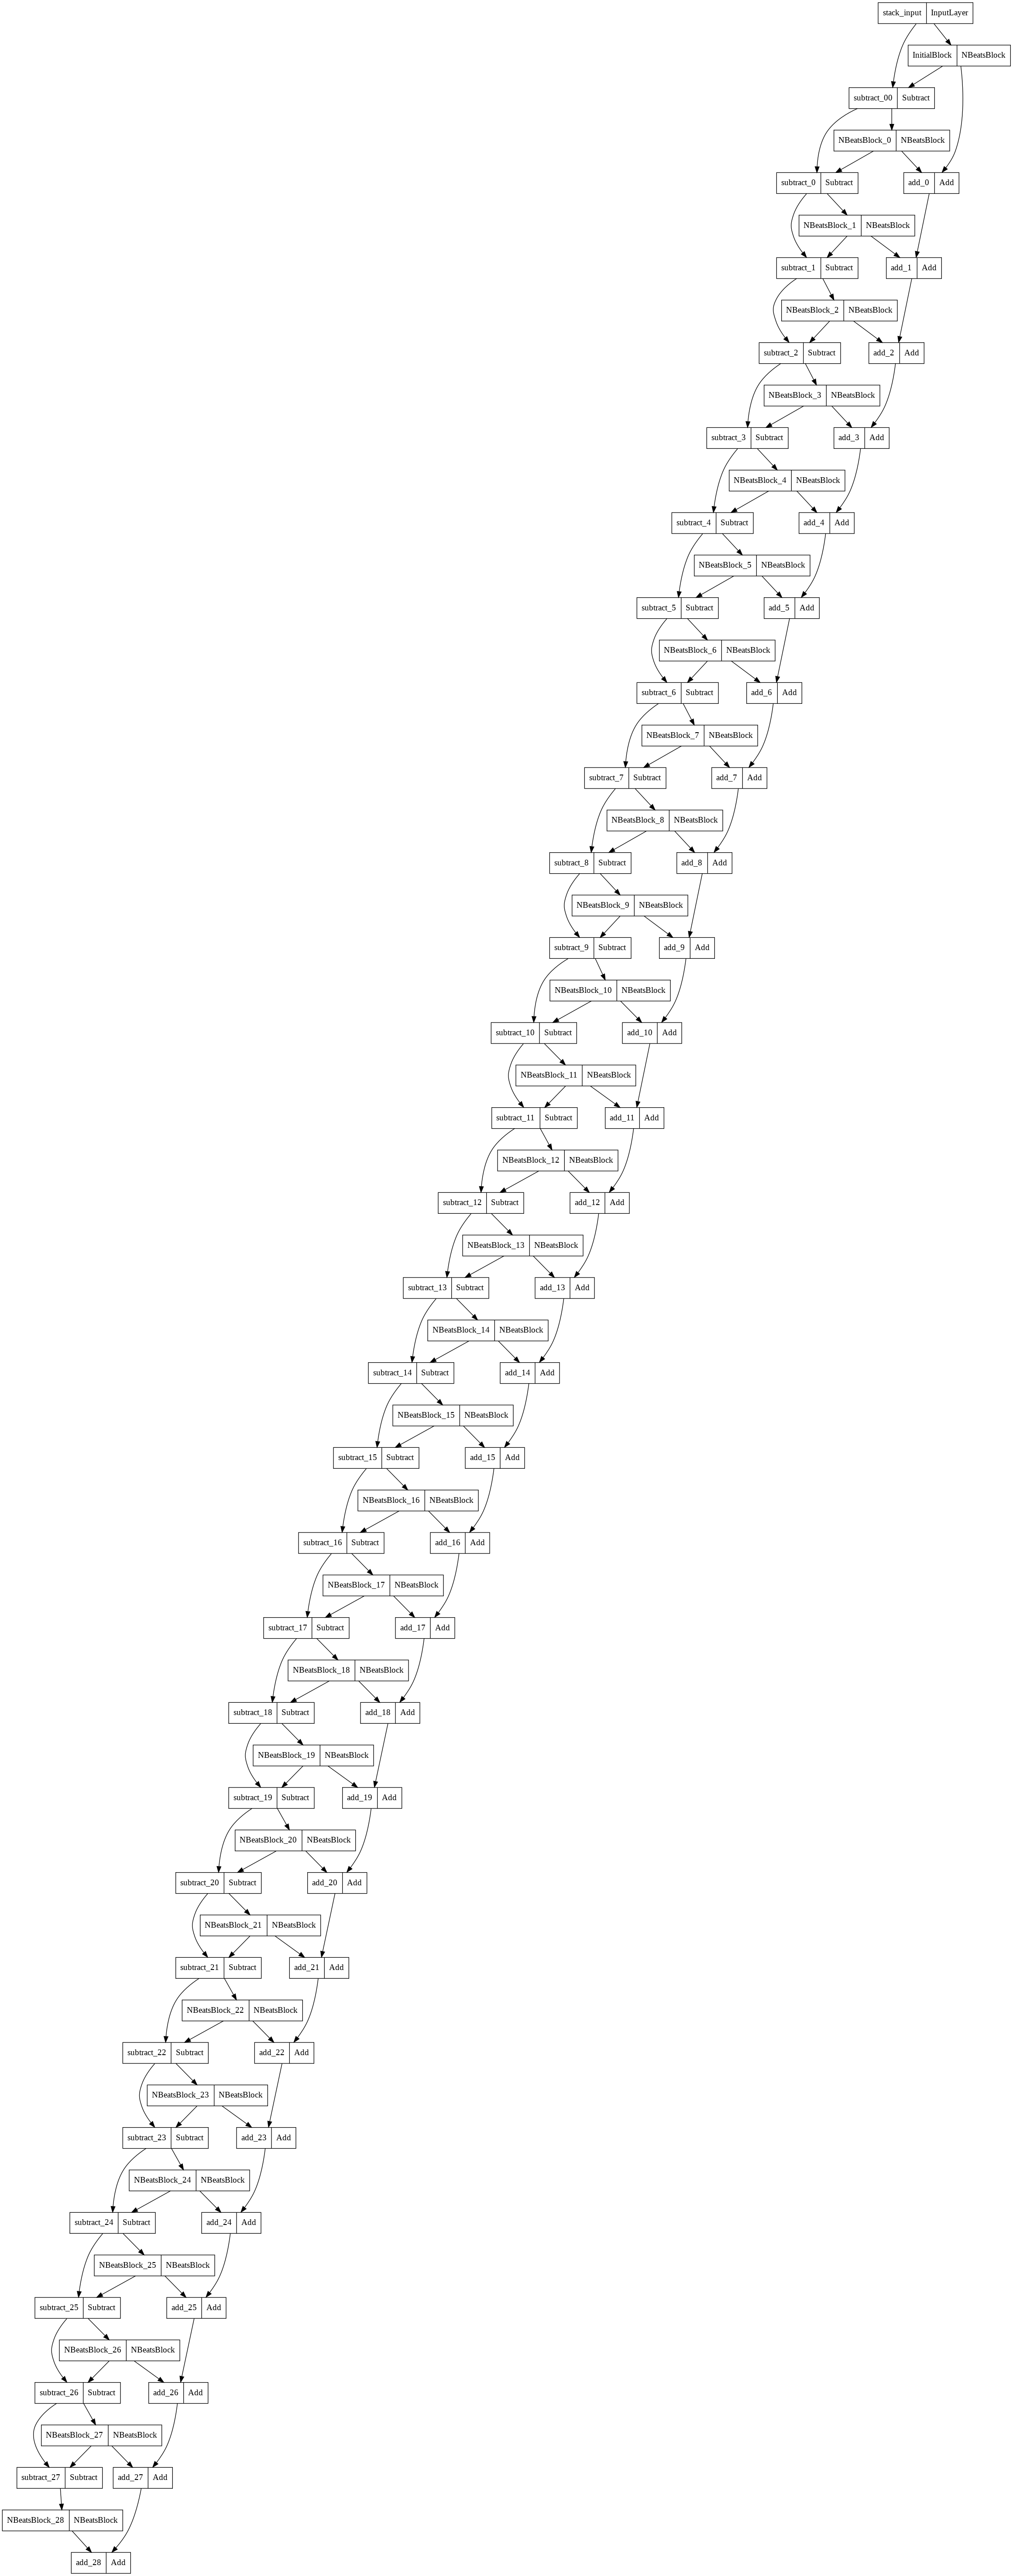

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_7)

## Model 8: Ensemble models


In [ ]:
def get_ensemble_models(horizon=HORIZON, 
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10, 
                        num_epochs=100, 
                        loss_fns=["mae", "mse", "mape"]):

  ensemble_models = []

  for i in range(num_iter):
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")


      model = tf.keras.Sequential([

        layers.Dense(128, kernel_initializer="he_normal", activation="relu"), 
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)                                 
      ])


      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      

      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      

      ensemble_models.append(model)

  return ensemble_models 

In [ ]:
%%time 

ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 682: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 945: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 507: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 607: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 165: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 282: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 382: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model number: 1
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 409: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 509: ReduceLROnPl

In [ ]:
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8790.299 ,  8762.831 ,  9019.502 , ..., 50064.082 , 49108.11  ,
        46422.54  ],
       [ 8786.574 ,  8740.881 ,  8995.682 , ..., 49024.043 , 48731.316 ,
        45520.543 ],
       [ 8732.57  ,  8719.407 ,  9093.386 , ..., 49921.9   , 47992.15  ,
        45316.45  ],
       ...,
       [ 8956.733 ,  8788.983 ,  9055.507 , ..., 49566.54  , 49786.92  ,
        46590.023 ],
       [ 8728.9375,  8808.11  ,  9102.179 , ..., 49591.867 , 48524.96  ,
        45084.395 ],
       [ 8823.311 ,  8768.297 ,  9047.492 , ..., 49759.906 , 48090.945 ,
        45874.336 ]], dtype=float32)>

In [ ]:
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0))
ensemble_results

{'mae': 566.7568,
 'mape': 2.5815542,
 'mase': 0.9956347,
 'mse': 1141795.6,
 'rmse': 1068.5485}

In [ ]:
def get_upper_lower(preds):

  std = tf.math.reduce_std(preds, axis=0)

  interval = 1.96 * std 

  preds_mean = tf.reduce_mean(preds, axis=0)
  
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper

lower, upper = get_upper_lower(preds=ensemble_preds)

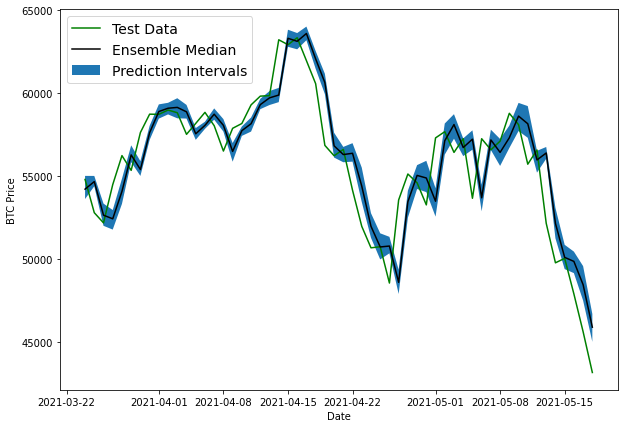

In [ ]:
ensemble_median = np.median(ensemble_preds, axis=0)

offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:], 
                 (lower)[offset:], 
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

## Model 9: Model on the full historical data

In [ ]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy()
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [ ]:
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
tf.random.set_seed(42)

model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

model_9.fit(dataset_all,
            epochs=100,
            verbose=0)

In [ ]:
INTO_FUTURE = 14

def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    future_forecast.append(tf.squeeze(future_pred).numpy())

    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [ ]:
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55764.46484375

Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55764.46484375] -> Prediction: 50985.9453125

Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55764.46484375 50985.9453125 ] -> Prediction: 48522.96484375

Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55764.46484375 50985.9453125  48522.96484375] -> Prediction: 48137.203125

Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 55764.46484375
 50985.9453125  48522.96484375 48137.203125  ] -> Prediction: 47880.63671875

Predicting on: 
 [45604.61575361 43144.47129086 55764.46484375 50985.9453125
 48522.96484375 48137.203125   47880.63671875] -> Prediction: 46879.71875

Predicting on: 
 [43144.47129086 55764.46484375 50985.9453125  48522.96